### Import stuff and setup

In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time
import pygmo as pg
from scipy.optimize import rosen
from Cython.Compiler import Options as cyOptions
from scipy.interpolate import UnivariateSpline

from runners.vStirap3lvlRunner import ExperimentalRunner, Atom, Cavity, LaserCoupling, CavityCoupling

In [22]:
def plot_results(results, ret_pulse_fun=False):
    
    exp_anX, exp_anY = results.get_cavity_number(cavity.R_CL)
    exp_emX, exp_emY = results.get_cavity_emission(cavity.R_CL)
    exp_anP, exp_anM = results.get_cavity_number(atom.R_AL)
    exp_emP, exp_emM = results.get_cavity_emission(atom.R_AL)
    
    exp_sp = results.get_total_spontaneous_emission()
    
    exp_atM, exp_atX, exp_atP, exp_atD = results.get_atomic_population(['gM', 'x0', 'gP', 'd'])
    
    t = results.output.times
    tStep = np.mean(np.ediff1d(t))
    
    n_X = np.trapz(exp_emX, dx=tStep)
    n_Y = np.trapz(exp_emY, dx=tStep)
    n_ph = n_X+n_Y
    n_sp = np.trapz(exp_sp, dx=tStep)
    
    plt.rcParams['text.usetex'] = True
    
    print('Photon emission:', np.round(n_ph,3))
    print('Photon emission in |X>, |Y>:', np.round(n_X,3), np.round(n_Y,3))
    print('Spontaneous emission:', np.round(n_sp,3))
    
    # Plot the results
    f1, ((a1a, a1b),
         (a2a, a2b)) = plt.subplots(2, 2, sharex=True, figsize=(12, 11./2))
    
    a1a.set_title('\\textbf{Cavity mode population}', fontsize=16)
    a1b.set_title('\\textbf{Cavity emission rate} ($1/\mu s$)', fontsize=16, fontweight='bold')
    
    ###
    axA,axB = a1a,a1b
    
    axA.plot(t, exp_anP, 'b', label='$+ (\sigma^{+})$')
    axA.plot(t, exp_anM, 'g', label='$- (\sigma^{-})$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emP, 'b', label='$+ (\sigma^{+})$')
    axB.plot(t, exp_emM, 'g', label='$- (\sigma^{-})$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    ###
    axA,axB = a2a,a2b
    
    axA.plot(t, exp_anX, 'b', label='$X$')
    axA.plot(t, exp_anY, 'g', label='$Y$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emX, 'b', label='$X$')
    axB.plot(t, exp_emY, 'g', label='$Y$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    f2, (a) = plt.subplots(1, 1, sharex=True, figsize=(12, 11/4))

    a.set_title('\\textbf{Atomic state}', fontsize=16)
    
    a.plot(t, exp_atM, 'b', label='$gM$')
    a.plot(t, exp_atP, 'g', label='$gP$')
    a.plot(t, exp_atX, '--r', label='$x0$')
    a.plot(t, exp_atD, '--y', label='$d$')
    
    a.set_xlabel('Time, $\mu s$')
    a.set_ylabel('Population')
    a.legend(loc=2)
    
    laser_couplings = results.hamiltonian.laser_couplings
    
    i_las = 1 if len(laser_couplings) > 1 else ''
    for laser_coupling in laser_couplings:
        omega = laser_coupling.omega0
        pulse = laser_coupling.pulse_shape
        args = laser_coupling.args_ham
        
        for k,v in args.items():
            if type(v)==np.ndarray:
                v = v.tolist()
            pulse = pulse.replace(k,str(v))
        if 'piecewise' in pulse:
            # Certain np functions (e.g. np.sin) don't play well with piecewise functions.
            # Fix is to have the function evaluated at every time, rather that over the time array.
            pulse = 'lambda t_list: ['+ pulse + ' for t in t_list]'
        else:
            pulse = 'lambda t: ' + pulse
        
        pulse_fn = eval(pulse)
        print(pulse)
        print(pulse_fn)
    
        for a in [a1a, a1b, 
              a2a, a2b,
              a]:
            aB = a.twinx()
            aB.plot(t, [np.abs(omega*x) for x in pulse_fn(t)], '--', label=str(i_las)+'$\Omega(t)$')
            aB.legend(loc=4)
        try:
            i_las+=1
        except:
            pass
        
        if ret_pulse_fun: return pulse_fn

### Pygmo testing

Define a problem with a similar architecture to our 'Runners' and 'Results' classes (but with a simpler Rosenbrock function to optimise), and compare how much quicker it is to parallelise different optimisations.

In [2]:
class DummeyRes():
    def __init__(self, res):
        self.res = res
        
    def get(self):
        return self.res

class DummeyExp():
    
    def __init__(self, args):
        self.args = args
        
    def run(self):
        
        return DummeyRes(rosen(self.args))
    
class BoundRosen():
    def __init__(self, dim):
        self.dim = dim
    
    def fitness(self, x):
        exp = DummeyExp(x)
        res = exp.run()
        return [res.get()] # pygmo requires fitness vectors
    
    def get_name(self):
        return "Bound Rosen"
    
    def get_extra_info(self):
        return "\tDimensions: " + str(self.dim)
    
    def get_bounds(self):
        return ([-5]*self.dim,[5]*self.dim)

In [3]:
%%timeit

i=0
while i<10:
    prob = pg.problem(BoundRosen(2000))
    # print(prob)
    # algo = pg.algorithm(pg.bee_colony(gen = 20, limit = 20))
    algo = pg.algorithm(pg.de(gen = 20))
    pop = pg.population(prob,100)
    pop = algo.evolve(pop)
    # print(pop.champion_f)
    i+=1

955 ms ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%%timeit

archi = pg.archipelago(n = 10,
                       algo = pg.de(gen = 20),
                       prob = pg.problem(BoundRosen(2000)),
                       pop_size = 100)
archi.evolve()
# print(archi)
archi.wait()
# archi.get_champions_f()

564 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Qutip optimisation

Ok, let's try to use this design pattern with our 'Runners'.

In [144]:
'''
Set up system
'''
gamma=3 * 2. * np.pi
branching_ratios = [0,0,1]

atom=Atom(gamma=gamma, branching_ratios=branching_ratios)

# g0=24 * (2*np.pi)
# kappa1,kappa2 = 19 * 2.*np.pi, 0.9 * 2.*np.pi
# deltaP = 20 * 2.*np.pi

g0=4 * (2*np.pi)
kappa1,kappa2 = 2 * 2.*np.pi, 2 * 2.*np.pi
deltaP = 0 * 2.*np.pi

cavity=Cavity(g=g0, kappa1=kappa1, kappa2=kappa2, deltaP=deltaP)

deltaC=0
cavity_couplings = []

for g_state, x_state, delta, deltaM in Atom.get_couplings_sigma_minus(deltaC):
    cavity_couplings.append(CavityCoupling(g0=cavity.g,
                                           g=g_state,
                                           x=x_state,
                                           deltaC=delta,
                                           deltaM=deltaM))
    
deltaL=0
length_pulse = 1
omega0=20 * 2 * np.pi
n_points = 7

x_list=np.array(np.linspace(0,length_pulse,n_points+2)).astype(float)
y_list=np.sin((np.pi/length_pulse) * x_list).astype(float)

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"length_pulse":float(length_pulse),
                                         "x_list":x_list,
                                         "y_list":y_list},
                               pulse_shape=("np.piecewise(t,"
                                            "[t<=length_pulse],"
                                            "[UnivariateSpline(x_list,y_list,s=0.1,k=3)" 
                                            ","
                                            "0])"),
                               setup_ham=["from scipy.interpolate import UnivariateSpline"]
                               )
cyOptions.error_on_unknown_names = True

In [145]:
t_length=1
n_steps=101
psi0=['gM',0,0]

omega_max = 50.0*2*np.pi
l_pulse_max = 0.4

omega_grad_max = omega_max / (l_pulse_max/5)
grad_penalty = 1/(n_points-1)
max_turns = 2
turning_penalty = 0.1

class PulseOptimisation():
    def __init__(self, dim):
        self.dim = dim
        self.n_points = self.dim - 2
    
    def fitness(self, x):
        length_pulse, omega = x[:2]
        t_list, dt =np.linspace(0,length_pulse,self.n_points, retstep=True)
        t_list=np.array(t_list).astype(float)
        # t_step = length_pulse / (self.n_points-1)
        y_list = x[2:]
        
        dy_list = np.diff(y_list)
        dydt_list = omega*np.abs(dy_list / dt)
        n_turns = np.sum(np.diff(np.signbit(dy_list)))
        # print(n_turns)
        # if n_turns > max_turns:
        #     return [turning_penalty]
        
        laser_coupling.omega0 = omega
        laser_coupling.args_ham['length_pulse'] = length_pulse
        laser_coupling.args_ham['x_list'] = t_list
        laser_coupling.args_ham['y_list'] = y_list 
        
        runner = ExperimentalRunner(atom=atom,
                                cavity=cavity,
                                laser_couplings=[laser_coupling],
                                cavity_couplings=cavity_couplings,
                                verbose=False)
        
        # results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
        results = runner.run(psi0=psi0, t_length=t_length, n_steps=n_steps)
        
        fit = 1-results.get_atomic_population(['gP'])[0][-1]
        # fit+=sum([grad_penalty if x else 0 for x in (dydt_list - omega_grad_max) > 0])
        # if n_turns > max_turns:
        #     fit+=turning_penalty*(n_turns-max_turns)
        # else: print('hit:', n_turns)
        
        return [fit]
        
        # return [1-results.get_atomic_population(['gP'])[0][-1]] + (dydt_list - omega_grad_max).tolist()
    
    def get_bounds(self):
        return ([0]*self.dim,[l_pulse_max, omega_max] + [0] + [1]*(self.n_points-2) + [0])
    
    # def get_nic(self):
    #     return self.n_points - 1
    #     
    # def get_nec(self):
    #     return 0
        
    def get_name(self):
        return "Pulse Optimisation"
    
    def get_extra_info(self):
        lb, ub = self.get_bounds()
        bounds = list(zip(*[lb,ub]))
        info = """Optimising over varable: limits
            length_pulse: {0}
            omega: {1}
            {2} pulse shape points: {3}""".format(bounds[0],bounds[1],self.n_points,bounds[3])
        
        return info

In [146]:
print(PulseOptimisation(n_points+2).get_extra_info())

Optimising over varable: limits
            length_pulse: (0, 0.4)
            omega: (0, 314.1592653589793)
            7 pulse shape points: (0, 1)


In [147]:
t_start = time.time()

archi = pg.archipelago(n = 4,
                       algo = pg.de(gen = 20),
                       prob = pg.problem(PulseOptimisation(n_points+2)),
                       pop_size = 20)
archi.evolve()
print(archi)
archi.wait()

print('Done in {0}s'.format(np.round(time.time()-t_start),3))

Number of islands: 4
Status: busy

Islands summaries:

	#  Type                    Algo                        Prob                Size  Status  
	-----------------------------------------------------------------------------------------
	0  Multiprocessing island  DE: Differential Evolution  Pulse Optimisation  20    busy    
	1  Multiprocessing island  DE: Differential Evolution  Pulse Optimisation  20    busy    
	2  Multiprocessing island  DE: Differential Evolution  Pulse Optimisation  20    busy    
	3  Multiprocessing island  DE: Differential Evolution  Pulse Optimisation  20    busy    



Done in 286.0s


Pop transfer of 64.263% with:
    length_pulse: 0.377us
    omega: 17.888MHz
    and pulse shape of...


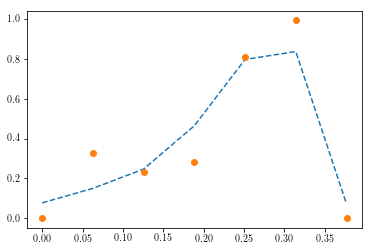

In [148]:
f_champs = archi.get_champions_f()
x_champs = archi.get_champions_x()

f_list = np.array([x[0] for x in f_champs])
i_champ = np.where(f_list==f_list.min())[0][0]

omega=x_champs[i_champ][1]
length_pulse = x_champs[i_champ][0]

print('''Pop transfer of {0}% with:
    length_pulse: {1}us
    omega: {2}MHz
    and pulse shape of...'''.format(*[np.round(x,3) for x in [100*(1-f_champs[i_champ][0]),
                                                              length_pulse,
                                                              omega/(2*np.pi)]])
      )

x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
y_list=x_champs[i_champ][2:]
pulse_fn = lambda t: np.piecewise(t, [t<=length_pulse], [UnivariateSpline(x_list,y_list,s=0.1,k=3),0])

plt.plot(x_list, pulse_fn(x_list),'--', x_list, y_list,'o')

Photon emission: 0.643
Photon emission in |X>, |Y>: 0.321 0.321
Spontaneous emission: 0.35


lambda t_list: [np.piecewise(t,[t<=0.377109913844],[UnivariateSpline([0.0, 0.06285165230735801, 0.12570330461471602, 0.18855495692207402, 0.25140660922943203, 0.31425826153679004, 0.37710991384414805],[0.0, 0.3261586399204043, 0.23201459338741415, 0.2832607348666103, 0.8086519288164091, 0.9952072570781694, 0.0],s=0.1,k=3),0]) for t in t_list]
<function <lambda> at 0x117104730>


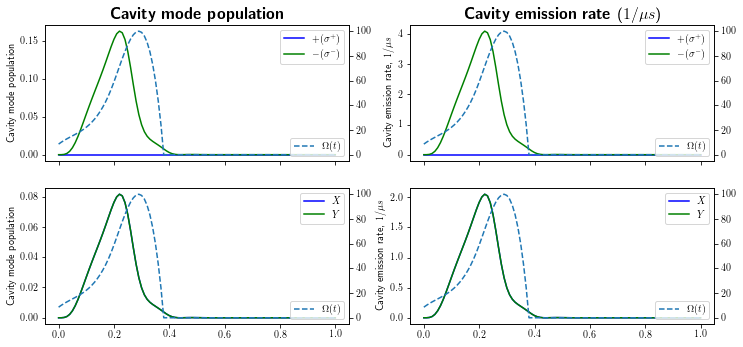

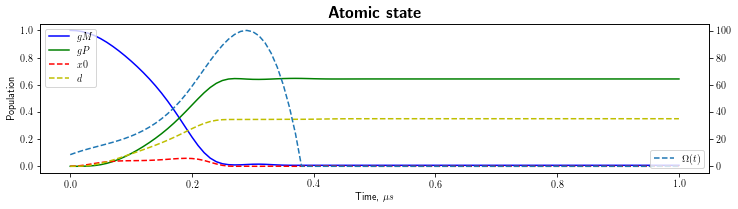

In [149]:
laser_coupling.omega0 = omega
laser_coupling.args_ham['length_pulse'] = length_pulse
laser_coupling.args_ham['x_list'] = x_list
laser_coupling.args_ham['y_list'] = y_list 

runner = ExperimentalRunner(atom=atom,
                        cavity=cavity,
                        laser_couplings=[laser_coupling],
                        cavity_couplings=cavity_couplings,
                        verbose=False)

results = runner.run(psi0=psi0, t_length=t_length, n_steps=n_steps)

plot_results(results)

In [83]:
f_list = np.array([x[0] for x in f_champs])
i_champ = np.where(f_list==f_list.min())[0][0]
print(i_champ)

2


In [107]:
x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
np.ediff1d(x_list)

array([ 0.0996513,  0.0996513,  0.0996513,  0.0996513,  0.0996513,
        0.0996513,  0.0996513,  0.0996513,  0.0996513,  0.0996513])